# Basic Molecular Dynamics Techniques
## NVE MD of a Lennard-Jones system
At the end of this notebook, there is a script for MD of a Lennard-Jones fluid in the $NVE$ ensemble.

1. In the code below, the function `lennard_jones_molecular_dynamics` should implement the time integration of an MD trajectory.
The time integration is missing!
Complete the code with your favourite integrator.

2. How is one able to control the temperature in NVE MD?
After all, the total energy of the system should be constant (not the temperature).

3. To test the energy drift $\Delta E$ of the numerical integration algorithm for a given time step $\Delta t$ after $N$ integration
steps, one usually computes
\begin{equation}
\Delta E\left(\Delta t\right) = \frac{1}{N} \sum_{i=1}^{i=N} \left|
\frac{E\left(0\right) - E\left(i\Delta t\right)}{E\left(0\right)}
\right|
\end{equation}
In this equation, $E\left(t\right)$ is the total energy (kinetic+potential) of the system at time $t$.

Compute $\Delta E$ and make a plot of $\Delta E$ as a function of the time step.
To maintain a certain energy drift, how does the time step have to change as a function of the temperature and density?

4.  An important quantity of a liquid or gas is the so-called self
diffusivity $D$. There are two methods to calculate $D$:
    1. by integrating the velocity autocorrelation function:
\begin{align}
D &= \frac{1}{3}\int_{0}^{\infty} \left\langle {\bf
v}\left(t\right)\cdot {\bf v}\left(t+t^{'}\right) \right\rangle
dt^{'}\nonumber\\
&= \frac{\int_{0}^{\infty} \sum_{i=1}^{i=N}
\left\langle{\bf v}\left(i,t\right)\cdot{\bf v}\left(i,t +
t^{'}\right)\right\rangle dt^{'}}{3N}
\end{align}
in which $N$ is the number of particles and ${\bf v}\left(i,t\right)$
is the velocity of particle $i$ at time $t$. One should choose $t$ in
such a way that independent time origins are taken, *i.e.* $t =
ia\Delta t$, $i=1,2, \cdots , \infty$ and $\left\langle {\bf
v}\left(t\right)\cdot{\bf v}\left(t+a\Delta t\right)\right\rangle
\approx {\bf 0}$ (why?).
    1. by calculating the mean square displacement:
\begin{equation}
D = \lim_{t^{'} \rightarrow \infty} \frac{\left\langle \left|{\bf
x}\left(t + t^{'}\right) - {\bf x} \left(t\right)\right|^{2}
\right\rangle}{6t^{'}}
\end{equation}
One should be very careful with the mean square displacement calculation when particles are always translated back to the central box---why?

Implement functions that calculate both MSD and VACF, and plot the both for some system parameters.
Why is it important to use only independent time origins for the calculation of the mean square displacement and the velocity autocorrelation function?
What is the unit of $D$ in SI units?
How can one transform $D$ into dimensionless units?

In [1]:
%load_ext cython

In [2]:
%%cython
import numpy as np
cimport numpy as np
import cython # 导入 cython 以使用装饰器

# 定义数据类型 (通常是 float64)
ctypedef np.float64_t DTYPE_t

# 使用 Cython 装饰器进行优化 (关闭边界检查和负索引，提高速度，但需确保索引安全)
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef msd2_cython_jupyter(np.ndarray[DTYPE_t, ndim=3] xs):
    """
    在 Cython 中计算均方差位移 (MSD) (适用于 Jupyter).

    Args:
        xs: np.ndarray[N_frames, N_atoms, 3] 粒子位置数组 (建议 float64).

    Returns:
        np.ndarray[N_frames] 包含每个时间延迟的 MSD.
    """
    # 使用 Py_ssize_t 获取维度，用于 C 级别的索引
    cdef Py_ssize_t N_frames = xs.shape[0]
    cdef Py_ssize_t N_atoms = xs.shape[1]
    cdef Py_ssize_t N_dims = xs.shape[2] # 假定是 3 维

    # 处理空数组的边缘情况
    if N_frames == 0 or N_atoms == 0:
        # 如果没有帧或原子，返回一个全零数组
        # 注意：这里直接调用 np.zeros，因为它在函数开始处，开销不大
        return np.zeros(N_frames, dtype=np.float64)

    # 创建类型化的输出数组 (在 nogil 块之外创建 NumPy 数组)
    cdef np.ndarray[DTYPE_t, ndim=1] msd_data = np.zeros(N_frames, dtype=np.float64)

    # 创建类型化的内存视图 (memoryviews) 以高效访问 C 级别的数据
    # '::1' 表示 C 连续内存布局 (NumPy 的默认布局)
    cdef DTYPE_t[:, :, ::1] xs_view = xs
    cdef DTYPE_t[:] msd_data_view = msd_data

    # 声明 C 语言变量
    cdef Py_ssize_t i, j, atom_idx, k
    cdef double squared_disp_atom, disp_k
    cdef double sum_sq_disp_atoms_pair # 对特定 (j, j+i) 对的所有原子求和
    cdef double total_mean_disp_lag   # 累加器，用于时间延迟 i 的最终 MSD 值
    cdef Py_ssize_t n_pairs          # 对于给定的延迟 i 有多少个帧对
    cdef double mean_disp_pair       # 一对 (j, j+i) 在所有原子上的平均平方位移

    # --- 主要计算循环 ---
    # 如果内部循环不涉及 Python 对象操作，可以考虑使用 'with nogil:' 释放 GIL
    # with nogil: # <-- 如果需要，取消注释此行并将下面的循环缩进

    # 遍历时间延迟 (i = delta_t)
    for i in range(N_frames):
        total_mean_disp_lag = 0.0
        n_pairs = N_frames - i # 当前时间延迟有多少个 (起始帧, 结束帧) 对

        # 如果 n_pairs 为 0 (即 i == N_frames)，则 MSD 为 0
        if n_pairs <= 0:
            msd_data_view[i] = 0.0
            continue # 继续下一个时间延迟 i

        # 遍历起始帧 (j)
        for j in range(n_pairs):
            sum_sq_disp_atoms_pair = 0.0
            # 遍历原子
            for atom_idx in range(N_atoms):
                squared_disp_atom = 0.0
                # 遍历维度 (x, y, z)
                for k in range(N_dims):
                    # 直接通过 memoryview 计算位移分量
                    disp_k = xs_view[j + i, atom_idx, k] - xs_view[j, atom_idx, k]
                    squared_disp_atom += disp_k * disp_k
                # 累加这个原子的平方位移大小
                sum_sq_disp_atoms_pair += squared_disp_atom

            # 计算这对 (j, j+i) 在所有原子上的平均平方位移
            mean_disp_pair = 0.0 # 默认为 0，以防 N_atoms 为 0
            if N_atoms > 0:
               mean_disp_pair = sum_sq_disp_atoms_pair / N_atoms

            # 将这对的平均位移累加到当前时间延迟 i 的总和中
            total_mean_disp_lag += mean_disp_pair

        # 在遍历完所有 j 对后，计算延迟 i 的最终 MSD
        # total_mean_disp_lag 是所有 n_pairs 个 mean_disp_pair 的总和
        # 所以除以 n_pairs 得到平均值
        msd_data_view[i] = total_mean_disp_lag / n_pairs

    # --- 循环结束 ---

    # 返回 NumPy 数组 (通过 memoryview 的修改已反映在原始数组中)
    return msd_data

(5000, 108, 3)
Diffusion coefficient D =  0.0801004262796071


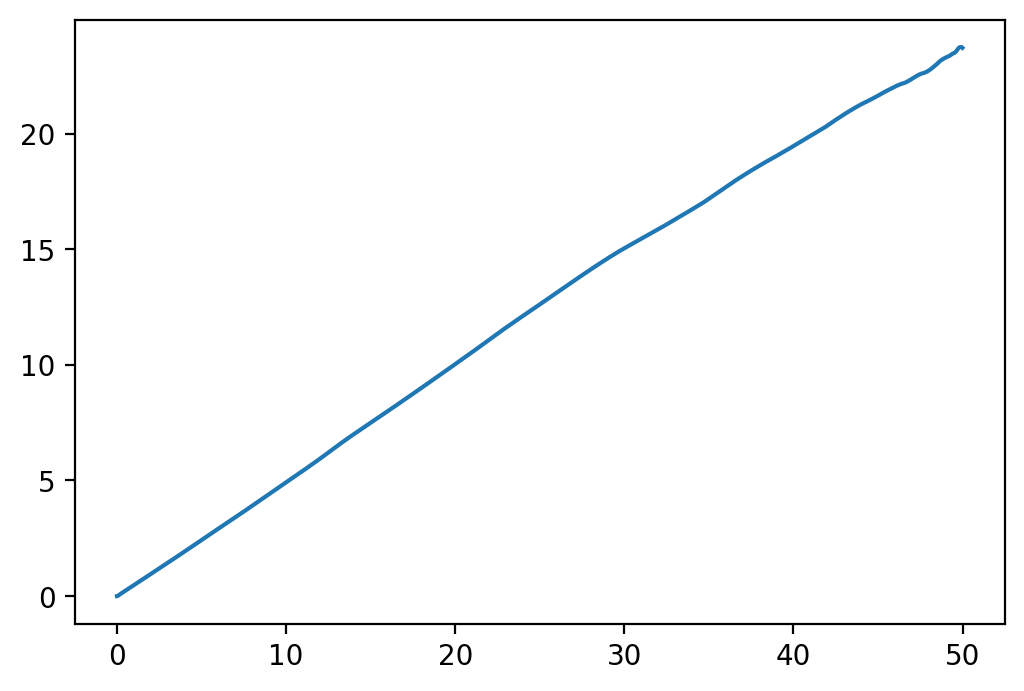

In [3]:
# python version code
import pickle
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
def msd_python(xs:np.ndarray):
    """
    xs: np.ndarray [N_frames,N_atoms,3]
    """
    # calculate the mean square displacement
    msd_data = np.zeros(xs.shape[0])
    for i in range(xs.shape[0]):
        msd_data[i] = np.mean(np.sum((xs[i] - xs[0])**2, axis=1))
    return msd_data

def msd2_python(xs:np.ndarray):
    """
    xs: np.ndarray [N_frames,N_atoms,3]
    """
    # calculate the mean square displacement
    msd_data = np.zeros(xs.shape[0])
    # iteration over all frames, 
    for i in range(xs.shape[0]):
        for j in range(0, xs.shape[0]-i):
            msd_data[i] += np.mean(np.sum((xs[j+i] - xs[j])**2, axis=1))
        msd_data[i] /= (xs.shape[0]-i)
    return msd_data

timestep = 0.001
steps_per_sample = 10
with open("md_simulation_data_timestep0.001.pkl", 'rb') as p:
    samples = pickle.load(p)

xs = np.array([sample['xs'] for sample in samples])
print(xs.shape)

#msd_data = msd_python(xs)
#msd_data = msd2_python(xs)
msd_data = msd2_cython_jupyter(xs)
plt.plot(timestep*steps_per_sample*np.arange(len(msd_data)), msd_data, label='Python')

# theory line : y = 6Dt, 
slope = np.polyfit(np.arange(len(msd_data)), msd_data, 1)[0]
print("Diffusion coefficient D = ", slope/6/timestep/steps_per_sample)

In [4]:
%%cython

import numpy as np
cimport numpy as np
import cython # 导入 cython 以使用装饰器

# 定义数据类型 (通常是 float64)
ctypedef np.float64_t DTYPE_t

# 使用 Cython 装饰器进行优化 (关闭边界检查和负索引，提高速度，但需确保索引安全)
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef corr(np.ndarray[DTYPE_t, ndim=3] vs):
    cdef Py_ssize_t N_frames = vs.shape[0]
    cdef Py_ssize_t N_atoms = vs.shape[1]
    cdef Py_ssize_t N_dims = vs.shape[2] # 假定是 3 维

    # define the result array
    cdef np.ndarray[DTYPE_t, ndim=1] corr_data = np.zeros(N_frames, dtype=np.float64)

    cdef Py_ssize_t i, j, atom_idx, k

    for i in range(N_frames):
        corr_data[i] = 0.0
        # average on the number of pairs and the number of atoms
        for j in range(N_frames - i):
            for atom_idx in range(N_atoms):
                for k in range(N_dims):
                    corr_data[i] += vs[j + i, atom_idx, k] * vs[j, atom_idx, k]

        corr_data[i] /= (N_frames - i) * N_atoms
    return corr_data

(5000, 108, 3)
(5000,)


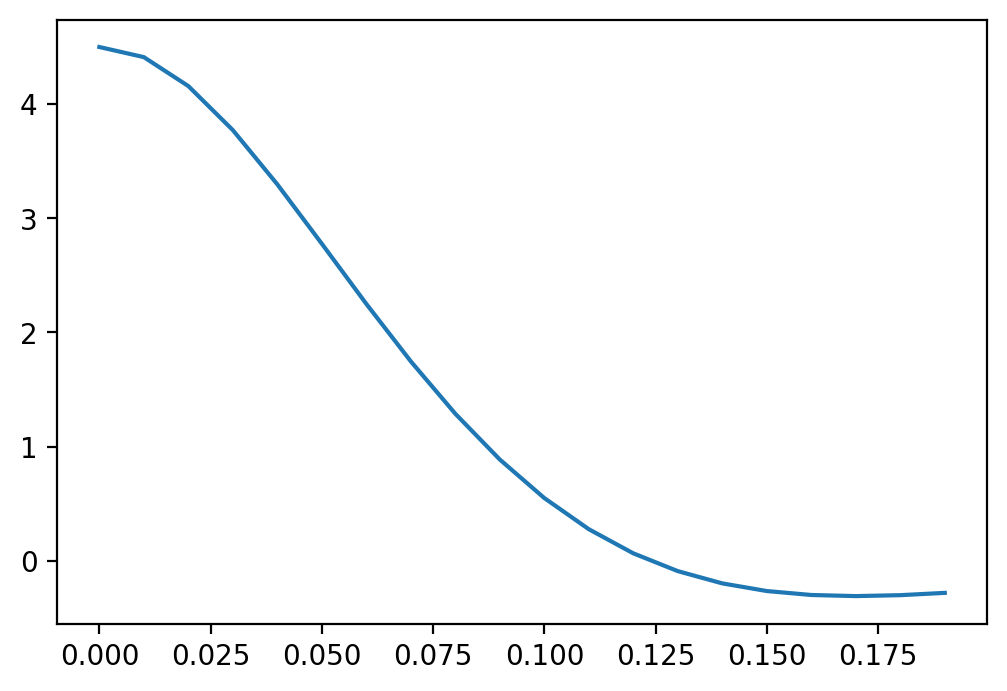

In [5]:
# calculate the autocorrelation of velocity
def autocorrelation(vs):
    """
    vs: np.ndarray [N_frames,N_atoms,3]
    return : np.ndarray [N_frames]
    """
    corr = np.zeros(vs.shape[0])
    for i in range(vs.shape[0]):
        for j in range(0, vs.shape[0]-i):
            corr[i] += np.mean(np.sum((vs[j+i] * vs[j]), axis=1))
        corr[i] /= (vs.shape[0]-i)
    return corr

vs = np.array([sample['vs'] for sample in samples])
print(vs.shape)
#vs_corr = autocorrelation(vs)
vs_corr = corr(vs)
print(vs_corr.shape)

plt.plot(timestep*steps_per_sample*np.arange(len(vs_corr[:20])), vs_corr[:20], label='Python')

0.0863155187103359


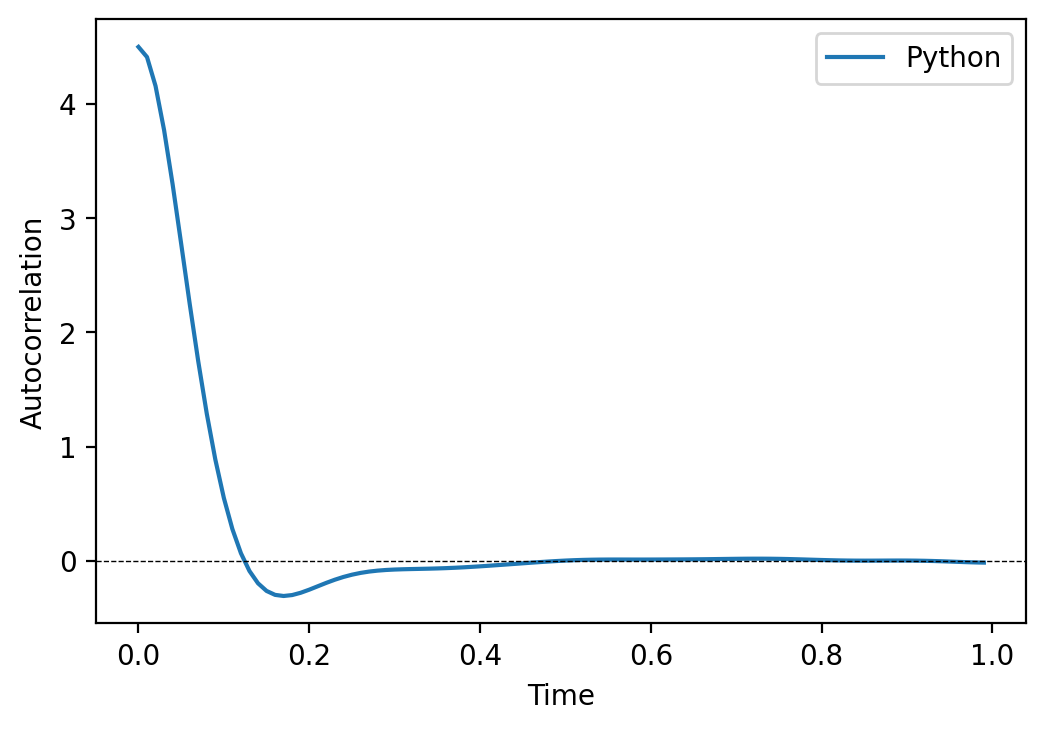

In [6]:
plt.plot(timestep*steps_per_sample*np.arange(len(vs_corr[:100])), vs_corr[:100], label='Python')

# set y=0 line
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.xlabel('Time')
plt.ylabel('Autocorrelation')
plt.legend()

# print(vs_corr[:100])
# integrate the autocorrelation to get the diffusion coefficient
def integrate_autocorrelation(corr, dt):
    """
    corr: np.ndarray [N_frames]
    dt: float
    return : float
    """
    D = 0.0
    for i in range(len(corr)):
        D += corr[i] * dt
    return D

D = integrate_autocorrelation(vs_corr[:50], timestep*steps_per_sample)
print(D/3)

5. For Lennard-Jones liquids, Naghizadeh and Rice report the following equation for the self diffusivity (dimensionless units,
$T^* <1.0$ and $p^* <3.0$)
\begin{equation}
{\rm ^{\rm 10}log}\left(D^* \right) = 0.05 + 0.07p^* - \frac{1.04 +
0.1p^*}{T^*}
\end{equation}
Try to confirm this equation with simulations. 

In [7]:
# calculat the pressure from radial distribution function
# plus the pressure tail or not compare
def pressure_virial(xs,fs,box_length):
    """
    xs: np.ndarray [N_frames,N_atoms,3]
    fs: np.ndarray [N_frames,N_atoms,3]
    return : float
    need considering the periodic boundary condition, not correct hear
    """
    virial_per_frame = np.sum(xs * fs, axis=(1, 2))
    virial = np.mean(virial_per_frame)
    return virial/ (3 * box_length**3)

def lj_force(r):
    """
    r: float
    return : float
    """
    # Lennard-Jones potential
    epsilon = 1.0
    sigma = 1.0
    r6 = (sigma / r) ** 6
    r12 = r6 * r6
    return 24 * epsilon * (2 * r12 - r6) / r

def pressure_gr(rdf,dr,density,r_cut=2.5):
    # integrate from 0 to rf
    if not isinstance(rdf, np.ndarray):
        rdf_array = np.array(rdf)
    else:
        rdf_array = rdf
    n_points = len(rdf_array)
    r_values = np.arange(dr/2, n_points * dr+dr/2, dr)
    integrand = r_values**3 * rdf_array* lj_force(r_values)
    integral_value = 0.0
    for i in range(n_points):
        integral_value += integrand[i] * dr
    return integral_value* (density**2) * (2 * np.pi / 3)

rdf = np.array([sample['rdf'] for sample in samples])
rdf = np.mean(rdf, axis=0)
density = 0.8442
temperature = 1.50
pressure = pressure_gr(rdf, 0.005, density)
print("viral pressure:", pressure)
print("pressure:",pressure+density*temperature)

# pressure from virial
box_length = samples[0]['box_length']
# fs = np.array([sample['fs'] for sample in samples])
virial = np.array([sample["virial"] for sample in samples])
virial = np.mean(virial, axis=0)
pressure = virial / (3 * box_length**3)
print("viral pressure:", pressure)
print("pressure:",pressure+density*temperature)

print("log10(D) = ", np.log10(D/3))
# theory: 0.05+0.07*p-(1.04+0.1*p)/T
print("theory: 0.05+0.07*p-(1.04+0.1*p)/T = ", 0.05+0.07*pressure-(1.04+0.1*pressure)/temperature)  

viral pressure: 3.5831818414236176
pressure: 4.849481841423618
viral pressure: 3.8874419793650636
pressure: 5.153741979365064
log10(D) =  -1.0639111152423493
theory: 0.05+0.07*p-(1.04+0.1*p)/T =  -0.6303751934021165


6. Instead of calculating the average potential $\left\langle U \right\rangle$ directly, one can use the radial distribution function
$g\left(r\right)$.
Derive an expression for $\left\langle U \right\rangle$ using $g\left(r\right)$.
Compare this calculation with a direct calculation of the average energy.
A similar method can be used to compute the average pressure.

In [8]:
def lj_energy(r):
    epsilon = 1.0
    sigma = 1.0
    r_safe = r + 1e-15
    r6 = (sigma / r_safe) ** 6
    r12 = r6 * r6
    return 4 * epsilon * (r12 - r6)

def potential_e_gr_improved(rdf, dr, r_cut):
    n_points = len(rdf)
    if n_points == 0:
        return 0.0
    r_values = np.array([(i + 0.5) * dr for i in range(n_points)])
    u_cut = lj_energy(r_cut)
    r_min_idx = 0
    for i in range(n_points):
        if r_values[i] >= 0.8:  # 选择一个合理的最小距离，比如 0.8σ
            r_min_idx = i
            break
            
    integrate_value = 0.0
    for i in range(r_min_idx, n_points):
        r = r_values[i]
        if r > r_cut:
            break
        u_r = lj_energy(r) - u_cut if r < r_cut else 0.0
        integrate_value += u_r * rdf[i] * r**2 * dr
    return integrate_value * 4 * np.pi

rdf = np.array([sample['rdf'] for sample in samples])
rdf = np.mean(rdf, axis=0)
density = 0.8442
temperature = 1.50
volume = box_length**3
num_particles = len(samples[0]['xs'])
integral_part = potential_e_gr_improved(rdf, 0.005,r_cut=2.5)

# 计算总势能 U = (N/2) * rho * I
potential_energy_rdf = (num_particles / 2.0) * density * integral_part

print("Potential energy from RDF:", potential_energy_rdf)

pe_simu = np.array([sample['pe'] for sample in samples])
pe_simu = np.mean(pe_simu, axis=0)
print("Potential energy from simulation:", pe_simu)

Potential energy from RDF: -477.45300251766474
Potential energy from simulation: -477.5282109899046


7. The radial distribution function can also be calculated from the forces on the particles as a time average over (see [here](https://doi.org/10.1080/00268976.2013.838316) and [here](https://doi.org/10.1063/5.0053737)):
\begin{equation}
g{(r}) = 1 + \frac{V}{N^{2}}\frac{\beta}{4\pi}\sum_{i}\sum_{j\ne i}\frac{\mathbf{f}_{i}-\mathbf{f}_{j}}{2}\cdot\frac{\mathbf{r}_{ij}}{r_{ij}^{3}}H{(r_{ij}-r)}
\end{equation}
where $H$ is Heaviside function,
\begin{equation}
H{(x)} = \begin{cases} 0 \quad\text{if }x<0\\
1\quad\text{otherwise.}
\end{cases}
\end{equation}
Compared to the standard histogram approach, in this force-based estimator, all pairs separated by a distance larger than $r$ contribute to the estimate of the RDF at $r$, which reduces the variance considerably.
In addition, no bins are necessary, and the RDF can be obtained with arbitrary resolution.
Try to implement this approach, and compare your results with those from the standard approach.

In [9]:
# code for calculate the radial distribution function by above given method
def force_based_rdf(xs, fs, box_length, r_values):
    """
    计算基于力的径向分布函数
    
    参数：
    xs: np.ndarray [N_particles, 3] - 粒子位置
    fs: np.ndarray [N_particles, 3] - 粒子力
    box_length: float - 模拟盒子长度
    r_values: np.ndarray - 要计算RDF的r值
    
    返回：
    np.ndarray - 对应r_values的g(r)值
    """
    particles = xs.shape[0]
    volume = box_length**3
    beta = samples[0]['beta']  # 从样本中获取beta值
    
    g_r = np.ones_like(r_values)  # 初始值设为1
    
    # 对每个r值计算RDF
    for r_idx, r in enumerate(r_values):
        sum_force_term = 0.0
        
        # 遍历所有粒子对
        for i in range(particles):
            for j in range(particles):
                if i == j:
                    continue
                
                # 计算粒子间距离向量，考虑周期性边界条件
                r_ij = xs[i] - xs[j]
                r_ij -= np.round(r_ij / box_length) * box_length
                r_ij_norm = np.linalg.norm(r_ij)
                
                # 只有当r_ij > r时才贡献（Heaviside函数）
                if r_ij_norm > r:
                    # 计算力差的点积与距离向量
                    force_diff = (fs[i] - fs[j]) / 2
                    dot_product = np.sum(force_diff * r_ij) / (r_ij_norm**3)
                    sum_force_term += dot_product
        
        # 应用公式
        g_r[r_idx] += (volume / (particles**2)) * (beta / (4 * np.pi)) * sum_force_term
    
    return g_r

In [9]:
%%cython
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def force_based_rdf_cython(double[:, ::1] xs, double[:, ::1] fs, double box_length, double[:] r_values, double beta):
    """
    使用基于力的方法计算径向分布函数（RDF）
    
    参数:
    xs: np.ndarray[N_particles, 3] - 粒子位置
    fs: np.ndarray[N_particles, 3] - 粒子力
    box_length: float - 模拟盒子长度
    r_values: np.ndarray - 要计算RDF的r值点
    beta: float - 1/kT
    
    返回:
    np.ndarray - 各r值点的g(r)值
    """
    cdef int particles = xs.shape[0]
    cdef int dimensions = xs.shape[1]
    cdef int n_r_values = r_values.shape[0]
    cdef double volume = box_length * box_length * box_length
    cdef double factor = (volume / (particles * particles)) * (beta / (4 * np.pi))
    
    # 创建结果数组
    cdef np.ndarray[double, ndim=1] g_r = np.ones(n_r_values, dtype=np.float64)
    cdef double[:] g_r_view = g_r
    
    # 临时变量
    cdef double r_ij_norm, dot_product, sum_force_term
    cdef int i, j, r_idx, d
    cdef double[3] r_ij, force_diff
    
    # 对每个r值计算RDF
    for r_idx in range(n_r_values):
        sum_force_term = 0.0
        
        # 遍历所有粒子对
        for i in range(particles):
            for j in range(particles):
                if i == j:
                    continue
                
                # 计算粒子间距离向量，考虑周期性边界条件
                r_ij_norm = 0.0
                for d in range(dimensions):
                    r_ij[d] = xs[i, d] - xs[j, d]
                    r_ij[d] -= round(r_ij[d] / box_length) * box_length
                    r_ij_norm += r_ij[d] * r_ij[d]
                
                r_ij_norm = np.sqrt(r_ij_norm)
                
                # 只有当r_ij > r时才贡献（Heaviside函数）
                if r_ij_norm > r_values[r_idx]:
                    # 计算力差
                    for d in range(dimensions):
                        force_diff[d] = (fs[i, d] - fs[j, d]) * 0.5
                    
                    # 计算点积
                    dot_product = 0.0
                    for d in range(dimensions):
                        dot_product += force_diff[d] * r_ij[d]
                    
                    # 除以r^3
                    dot_product /= (r_ij_norm * r_ij_norm * r_ij_norm)
                    
                    # 累加结果
                    sum_force_term += dot_product
        
        # 更新g(r)
        g_r_view[r_idx] += factor * sum_force_term
    
    return g_r

load rdf data from samples


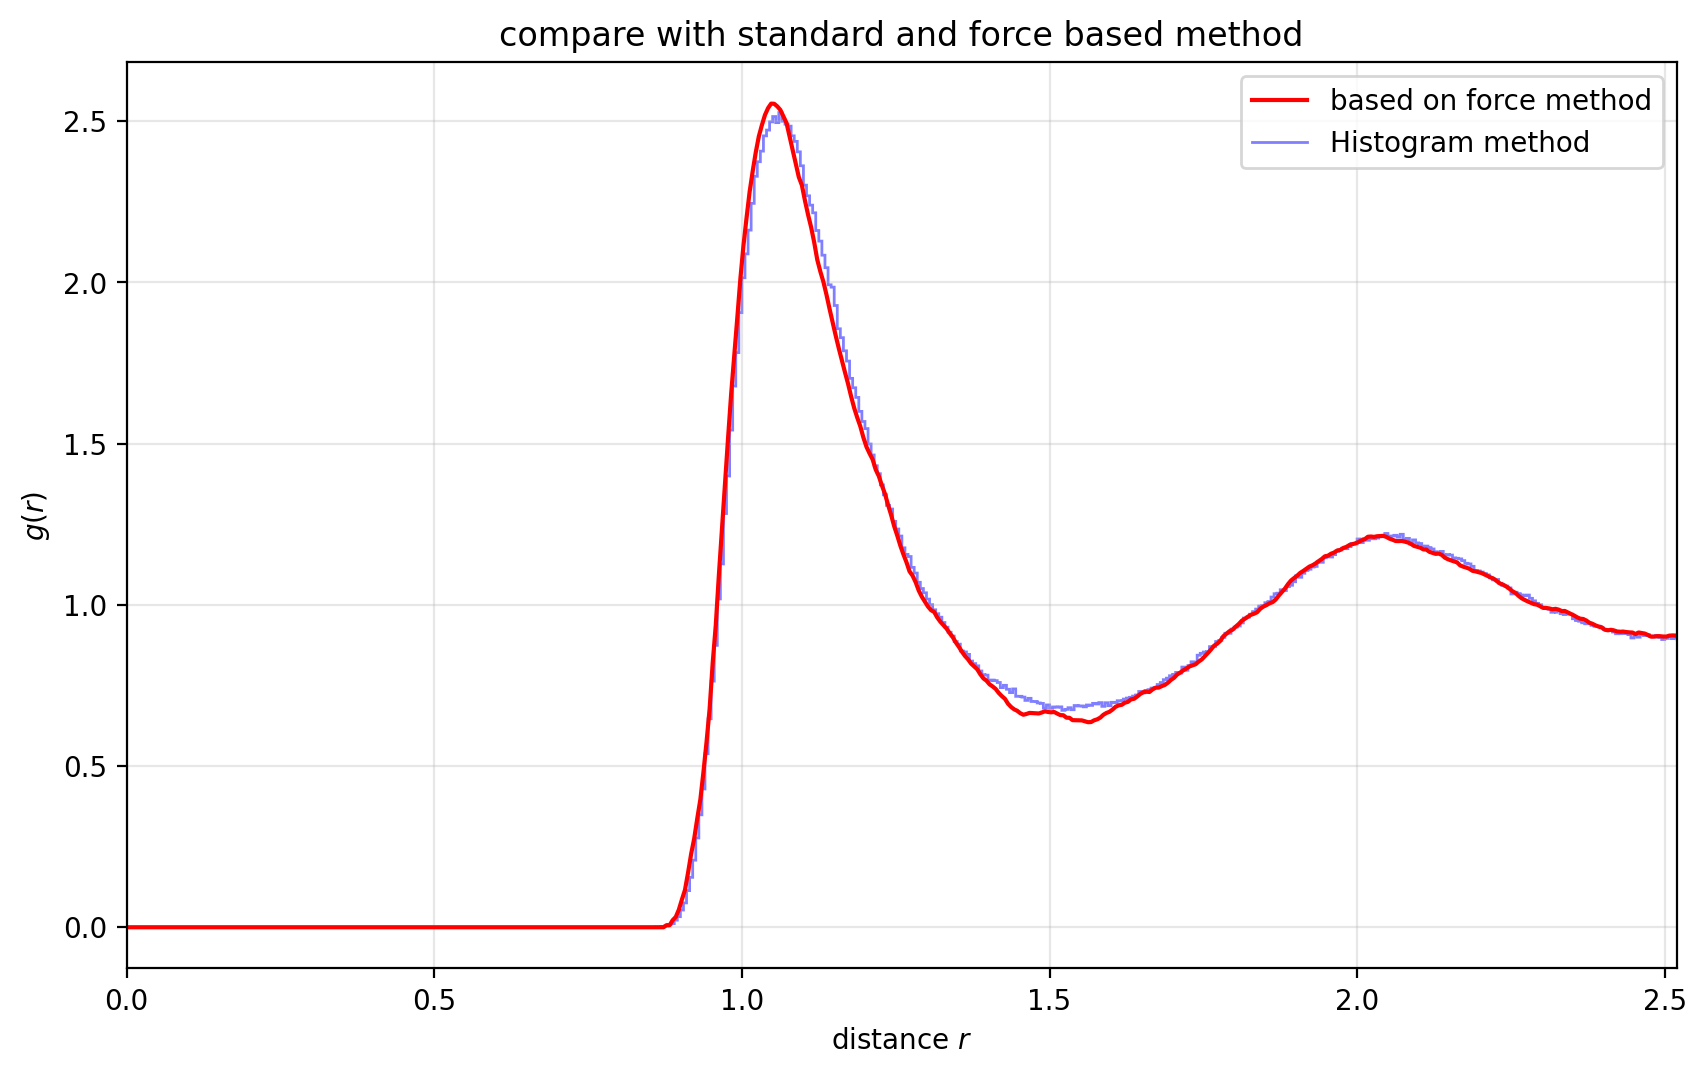

In [18]:
def compare_rdf_methods():
    # 从保存的模拟数据加载样本
    with open("md_simulation_data_timestep0.001.pkl", 'rb') as p:
        samples = pickle.load(p)
    
    # 获取模拟参数
    box_length = samples[0]['box_length']
    beta = samples[0]['beta']
    dr = samples[0]['dr']
    
    # 计算标准RDF（直方图方法）
    standard_rdfs = np.array([sample["rdf"] for sample in samples])
    avg_standard_rdf = np.mean(standard_rdfs, axis=0)
    print("load rdf data from samples")

    plt.figure(figsize=(10, 6))

    # 直方图方法
    bin_edges = np.arange(0, len(avg_standard_rdf)+1) * dr
    plt.stairs(avg_standard_rdf, bin_edges, label='Histogram method', color='blue', alpha=0.5)
    
    # 为基于力的方法定义r值点
    r_values = np.arange(dr/2, min(box_length/2, 5.0), dr)
    
    # 初始化基于力的RDF数组
    force_based_rdfs = np.zeros((len(samples), len(r_values)))
    
    # 计算每个样本的基于力的RDF
    xs = np.array([sample['xs'] for sample in samples])
    fs = np.array([sample['fs'] for sample in samples])
    average_num = 50
    for i in range(average_num):
        
        # 使用Cython版本计算
        force_based_rdfs[i] = force_based_rdf_cython(xs[i], fs[i], box_length, r_values, beta)
    
    # 计算平均值
    avg_force_based_rdf = np.mean(force_based_rdfs[:average_num], axis=0)
    
    # 绘制比较图
    
    
    # 基于力的方法
    plt.plot(r_values, 2-avg_force_based_rdf, 'r-', label='based on force method')
    
    plt.xlabel('distance $r$')
    plt.ylabel('$g(r)$')
    plt.title('compare with standard and force based method')
    plt.legend()
    plt.xlim(0, min(box_length/2, 5.0))
    plt.grid(alpha=0.3)
    
    return avg_standard_rdf, avg_force_based_rdf, r_values

# 执行比较
std_rdf, force_rdf, r_vals = compare_rdf_methods()

In [ ]:
#!pip install --upgrade cython

In [ ]:
%load_ext Cython

In [29]:
%%cython

from cython.cimports.libc.math import sqrt, rint, INFINITY, floor, ceil
import cython
import numpy as np


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def lennard_jones_energy_virial(xs: cython.double[:, ::1], box_length: cython.double, rcut: cython.double) -> cython.tuple[float, float]:
    """ Compute the energy and virial of a system of Lennard Jones particles. """
    particles: cython.int = xs.shape[0]
    dimensions: cython.int = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    energy = 0.0
    virial = 0.0

    rcut2 = rcut * rcut
    rcut6 = 1.0 / rcut2
    rcut6 *= rcut6 * rcut6
    ecut = 4.0 * rcut6 * (rcut6 - 1)

    for i in range(particles):
        for j in range(i + 1, particles):
            r2 = 0.0
            for d in range(dimensions):
                rijd = xs[i, d] - xs[j, d]
                rijd -= rint(rijd / box_length) * box_length
                r2 += rijd * rijd
            if r2 > rcut2:
                continue
            r6 = 1 / r2
            r6 *= r6 * r6
            energy += 4.0 * r6 * (r6 - 1.0) - ecut
            virial += 48.0 * r6 * (r6 - 0.5)
    return energy, virial


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def lennard_jones_force(xs: cython.double[:, ::1], box_length: cython.double, rcut: cython.double) -> np.ndarray:
    """ Compute the forces on a system of Lennard-Jones particles. """
    particles: cython.int = xs.shape[0]
    dimensions: cython.int = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    rcut2 = rcut * rcut
    fs: cython.double[:, ::1] = np.zeros_like(xs)
    rij: cython.double[::1] = np.zeros(dimensions)
    
    for i in range(particles):
        for j in range(i + 1, particles):
            r2 = 0.0
            for d in range(dimensions):
                rij[d] = xs[i, d] - xs[j, d]
                rij[d] -= rint(rij[d] / box_length) * box_length
                r2 += rij[d] * rij[d]
            if r2 > rcut2:
                continue
            r6 = 1.0 / r2
            r6 *= r6 * r6
            fij = 48.0 * r6 * (r6 - 0.5) / r2 # divided by r2 to get the force/r 
            for d in range(dimensions):
                fs[i, d] += fij * rij[d]
                fs[j, d] -= fij * rij[d]
    return np.array(fs)


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def rdf(xs: cython.double[:, ::1], box_length: cython.double, rcut: cython.double, dr: cython.double) -> cython.double[::1]:
    """ Accumulate the non-normalised radial distribution function """
    particles: cython.int = xs.shape[0]
    dimensions: cython.int = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    b: cython.Py_ssize_t
    bins = <int>ceil(sqrt(3.0)*box_length / 2.0 / dr)
    histogram: cython.double[::1] = np.zeros(bins)
    bin_edges = np.arange(0, bins + 1) * dr
    density = particles / box_length ** 3
    factor: cython.double[::1] = 4.0 / 3.0 * np.pi * (bin_edges[1:bins + 1] ** 3 - bin_edges[0:bins] ** 3) * density * particles

    for i in range(particles):
        for j in range(i + 1, particles):
            r2 = 0.0
            for d in range(dimensions):
                rijd = xs[i, d] - xs[j, d]
                rijd -= rint(rijd / box_length) * box_length
                r2 += rijd * rijd
            r = sqrt(r2)
            b = <Py_ssize_t>floor(r / dr)
            histogram[b] += 2.0
            
    return np.array(histogram)/factor

In [30]:
import numpy as np
from scipy.optimize import minimize


def get_initial_configuration(particles, dimensions, box_length, rcut):
    """ use scipy functions to minimize the energy of a random configuration """
    
    def func(xs):
        return lennard_jones_energy_virial(xs.reshape(particles, dimensions), box_length, rcut)[0]
    def jac(xs):
        return -lennard_jones_force(xs.reshape(particles, dimensions), box_length, rcut).reshape(-1)

    xs = np.random.rand(particles * dimensions) * box_length
    ret = minimize(func, x0=xs, jac=jac)
    return ret.x.reshape(particles, dimensions)

In [31]:
def sample(xs: np.ndarray, vs: np.ndarray, fs: np.ndarray, box_length: float, rcut: float, dr: float, beta: float, samples:[dict] = None) -> [dict]:
    """
    Accumulate samples from a trajectory frame.
    You can calculate anything you like and save it for later.
    """
    if samples is None:
        samples = []
        
    particles = xs.shape[0]
    pe, virial = lennard_jones_energy_virial(xs, box_length, rcut)
    ke = 0.5 * (vs ** 2).sum()
    samples.append({
        'xs': xs.copy(),
        'vs': vs.copy(),
        'fs': fs.copy(),
        'pe': pe,
        'ke': ke,
        'energy': pe + ke,
        'virial': virial,
        'box_length': box_length,
        'rcut': rcut,
        'dr': dr,
        'beta': beta,
        'rdf': rdf(xs, box_length, rcut, dr).copy()
    })
    return samples


def lennard_jones_molecular_dynamics(
    xs: np.ndarray,
    vs: np.ndarray,
    box_length: float,
    rcut: float,
    dr: float,  # for rdf
    beta: float,  # for other rdf
    timestep: float,
    steps: int,
    steps_per_sample: int,
    rescale_temperature: bool = False
):
    """
    Run some NVE MD.

    xs, vs, and fs are the coordinates, velocities, and forces, respectively.    
    """
    samples = None
    
    fs = lennard_jones_force(xs, box_length, rcut)

    for step in range(steps):
        # integrate, use velocity Verlet
        xs[:] += vs * timestep + 0.5 * fs * timestep * timestep
        fs_old = fs.copy()
        fs[:] = lennard_jones_force(xs, box_length, rcut)
        vs[:] += 0.5 * (fs + fs_old) * timestep

        if rescale_temperature:
            vs /= np.sqrt(beta*(vs**2).sum()/(3*vs.shape[0]-3))
        
        if step % steps_per_sample == 0:
            samples = sample(xs, vs, fs, box_length, rcut, dr, beta, samples)
        if step % 1000 == 0:
            print(f"\rlennard_jones_molecular_dynamics> step: {step}", end="")
    print()
    return samples


In [32]:
from itertools import product
import numpy as np


"""
Run NVE MD of a Lennard-Jones system.
"""

# set up the system
particles = 108
dimensions = 3

rcut = 2.5
temperature = 1.50
beta = 1 / temperature
timestep = 0.001
steps = 50000
steps_per_sample = 10
equilibration_samples = 0
density = 0.8442
box_length = (particles / density) ** (1 / dimensions)
dr = 0.005

if box_length < 2 * rcut:
    raise ValueError("rcut too large for this box (2 * rcut = {2*rcut} > {box_length} = box_length)")

# initial positions & velocities
xs = get_initial_configuration(particles, dimensions, box_length, rcut)
vs = np.random.randn(xs.size).reshape(xs.shape)
vs -= vs.mean(0)
vs *= np.sqrt(temperature * (3 * particles - 3)/(vs ** 2).sum())

# equilibration
print("equilibrating...")
samples = lennard_jones_molecular_dynamics(
    xs, vs, box_length, rcut, dr, beta, timestep, 5000, steps_per_sample, rescale_temperature=True
)
xs, vs = samples[-1]['xs'], samples[-1]['vs']
# production
print("sampling...")
samples = lennard_jones_molecular_dynamics(
    xs, vs, box_length, rcut, dr, beta, timestep, steps, steps_per_sample
)

with open(f"md_simulation_data_timestep{timestep}.pkl", 'wb') as p:
    pickle.dump(samples, p)

equilibrating...
lennard_jones_molecular_dynamics> step: 4000
sampling...
lennard_jones_molecular_dynamics> step: 49000


Text(0, 0.5, '$g{(r)}$')

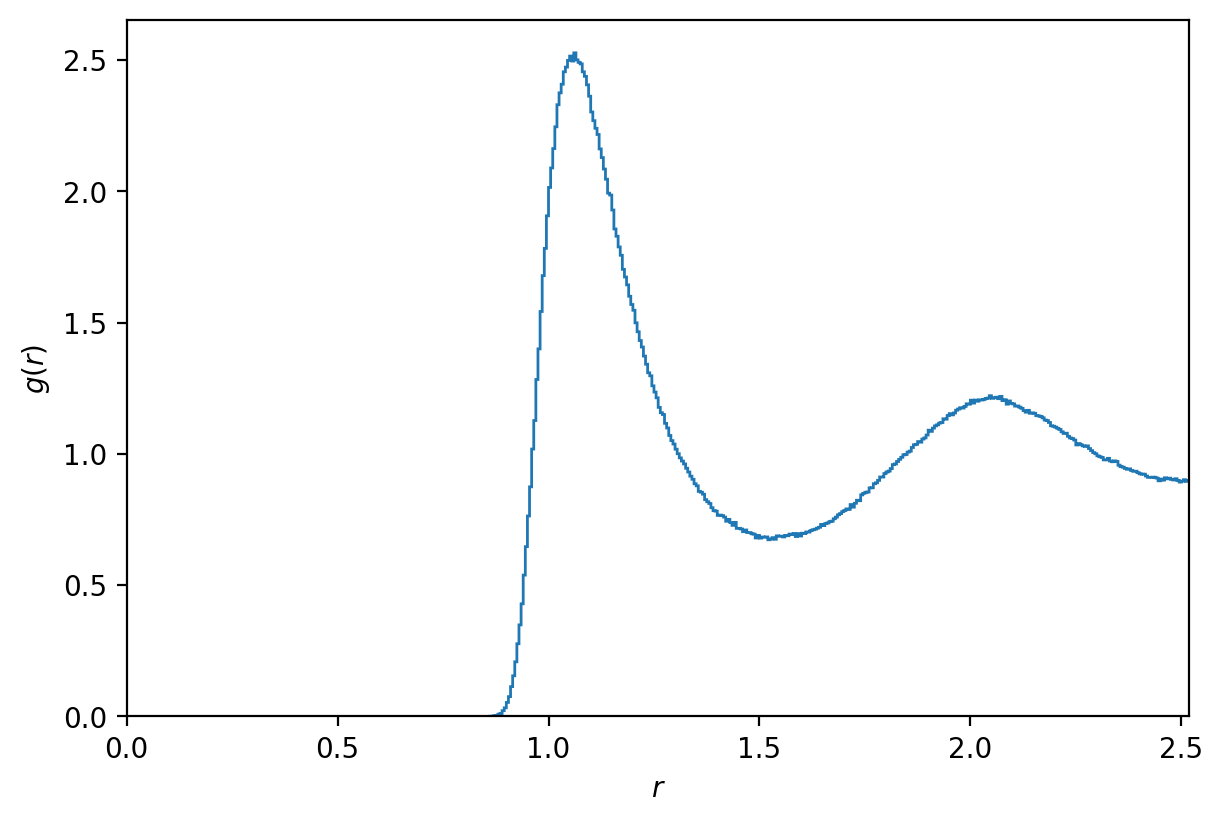

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200

"""
Analyse a Lennard-Jones NVE MD trajectory.
"""

# do some analysis

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,4))

dr = samples[0]['dr']
box_length = samples[0]['box_length']

rdfs = np.array([sample["rdf"] for sample in samples]).mean(0)
bin_edges = np.arange(0, np.sqrt(3) * box_length / 2 + dr, dr)
ax.stairs(rdfs, bin_edges)
ax.set_xlim(0, box_length/2)
ax.set_xlabel("$r$")
ax.set_ylabel("$g{(r)}$")

In [ ]:
plt.figure(2)

ke = np.array([sample['ke'] for sample in samples])
pe = np.array([sample['pe'] for sample in samples])
energy = np.array([sample['energy'] for sample in samples])
plt.plot(timestep * steps_per_sample * np.arange(len(ke)), ke, label='Kinetic Energy')
plt.plot(timestep * steps_per_sample * np.arange(len(pe)), pe, label='Potential Energy')
plt.plot(timestep * steps_per_sample * np.arange(len(energy)), energy, label='Total Energy')
plt.xlabel("Time")
plt.ylabel("Energy")
